In [48]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np

In [49]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K

In [50]:
iv3 = InceptionV3()

In [51]:
print(iv3.summary())

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

In [52]:
from keras.preprocessing import image

In [53]:
x = image.img_to_array(image.load_img("./images/cat.jpg", target_size = (299, 299)))
x /= 255
x -= 0.5
x *= 2
x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
y = iv3.predict(x)
y.shape
decode_predictions(y)

[[('n02123045', 'tabby', 0.69327),
  ('n02123159', 'tiger_cat', 0.1386224),
  ('n02127052', 'lynx', 0.091986455),
  ('n02124075', 'Egyptian_cat', 0.022501227),
  ('n02129604', 'tiger', 0.002324713)]]

In [67]:
x = image.img_to_array(image.load_img("./images/hacked.png", target_size = (299, 299)))
x /= 255
x -= 0.5
x *= 2
x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
y = iv3.predict(x)
y.shape
decode_predictions(y)

[[('n07749582', 'lemon', 0.9984268),
  ('n07747607', 'orange', 0.00014357641),
  ('n04367480', 'swab', 0.00010783507),
  ('n02123159', 'tiger_cat', 0.00010781882),
  ('n07930864', 'cup', 8.2783685e-05)]]

## Ataques adversarios ...

In [55]:
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

print(out_layer)

Tensor("predictions_1/Softmax:0", shape=(None, 1000), dtype=float32)


In [56]:
target_class = 951
loss = out_layer[0, target_class]

grad = K.gradients(loss, inp_layer)[0]

In [57]:
grad

<tf.Tensor 'gradients_2/conv2d_95/convolution_grad/Conv2DBackpropInput:0' shape=(None, 299, 299, 3) dtype=float32>

In [64]:
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])

adv = np.copy(x)

max_pert = x + 0.01
min_pert = x - 0.01

cost = 0.0
while cost < 0.95:
    gr, cost = optimize_gradient([adv, 0])
    adv += gr
    adv = np.clip(adv, min_pert, max_pert)
    adv = np.clip(adv, -1, 1)
    print("Target cost: ", cost)
    
hacked = np.copy(adv)

Target cost:  0.9948395


In [65]:
adv /= 2
adv += 0.5
adv *= 255

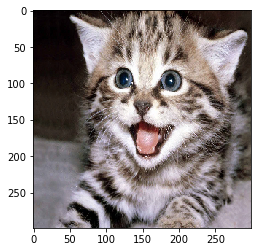

In [66]:
plt.imshow(adv[0].astype(np.uint8))
plt.show()

In [61]:
from PIL import Image
im = Image.fromarray(adv[0].astype(np.uint8))
im.save("images/hacked.png")

In [62]:
from tensorflow.python.client import device_lib

In [63]:
def get_aviable_devices():
    local_devices_protos = device_lib.list_local_devices()
    return [x.name for x in local_devices_protos]

print(get_aviable_devices())

['/device:CPU:0', '/device:GPU:0']
